In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
# train_ds, val_ds, label_names = dataset_tf("./dataset/pitched_transformed_train", 0.50, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_1", 0.80, 8)

Found 130 files belonging to 2 classes.
Using 26 files for training.
Using 104 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (8, 4000)
Example label shape: (8,)


2024-03-31 17:45:59.109965: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-31 17:45:59.109992: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-31 17:45:59.110001: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-31 17:45:59.110043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 17:45:59.110073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

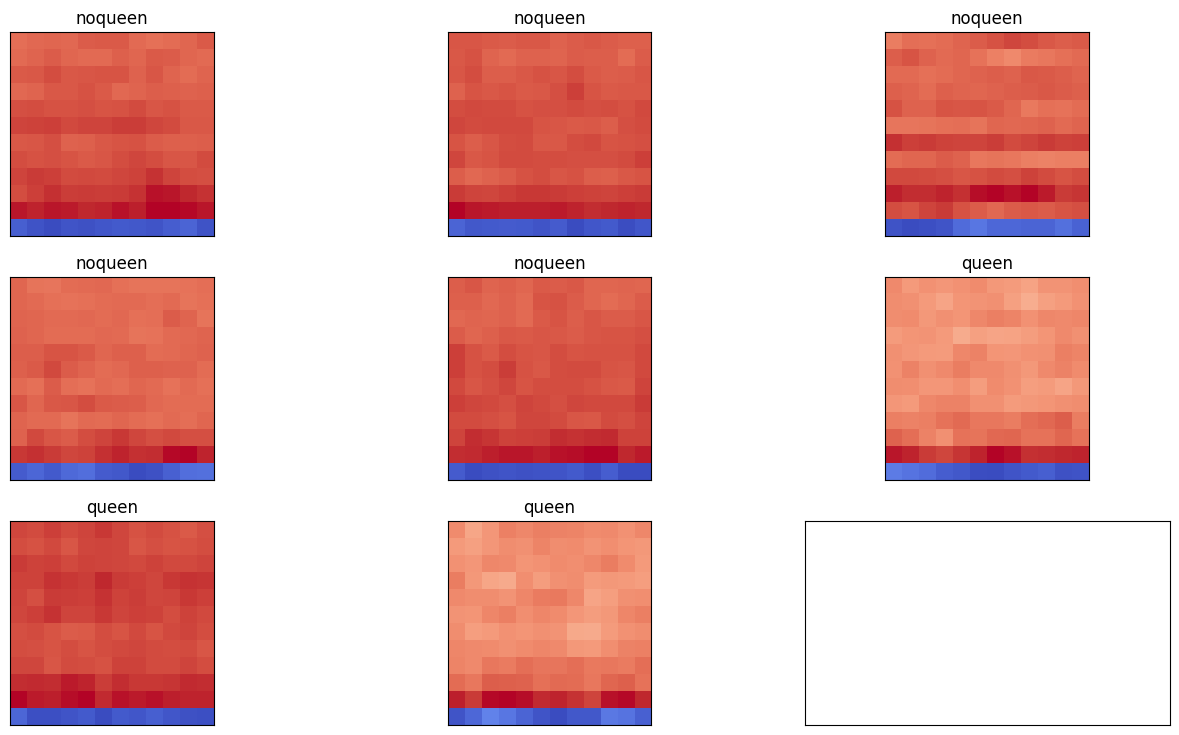

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-31 17:46:00.395942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2024-03-31 17:46:00.946813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


4/4 [==============================] - 1s 149ms/step - loss: 0.7345 - accuracy: 0.3846 - val_loss: 0.7215 - val_accuracy: 0.3750
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 0.6899 - accuracy: 0.4231 - val_loss: 0.7116 - val_accuracy: 0.3750
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 0.6570 - accuracy: 0.6154 - val_loss: 0.7226 - val_accuracy: 0.3750
Epoch 4/10
4/4 [==============================] - 0s 34ms/step - loss: 0.6368 - accuracy: 0.6538 - val_loss: 0.7259 - val_accuracy: 0.3750
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 0.6236 - accuracy: 0.6154 - val_loss: 0.7242 - val_accuracy: 0.3750
Epoch 6/10
4/4 [==============================] - 0s 33ms/step - loss: 0.6108 - accuracy: 0.6154 - val_loss: 0.7206 - val_accuracy: 0.3750
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 0.6009 - accuracy: 0.7308 - val_loss: 0.7193 - val_accuracy: 0.3750
Epoch 8/10
4/4 [=====================

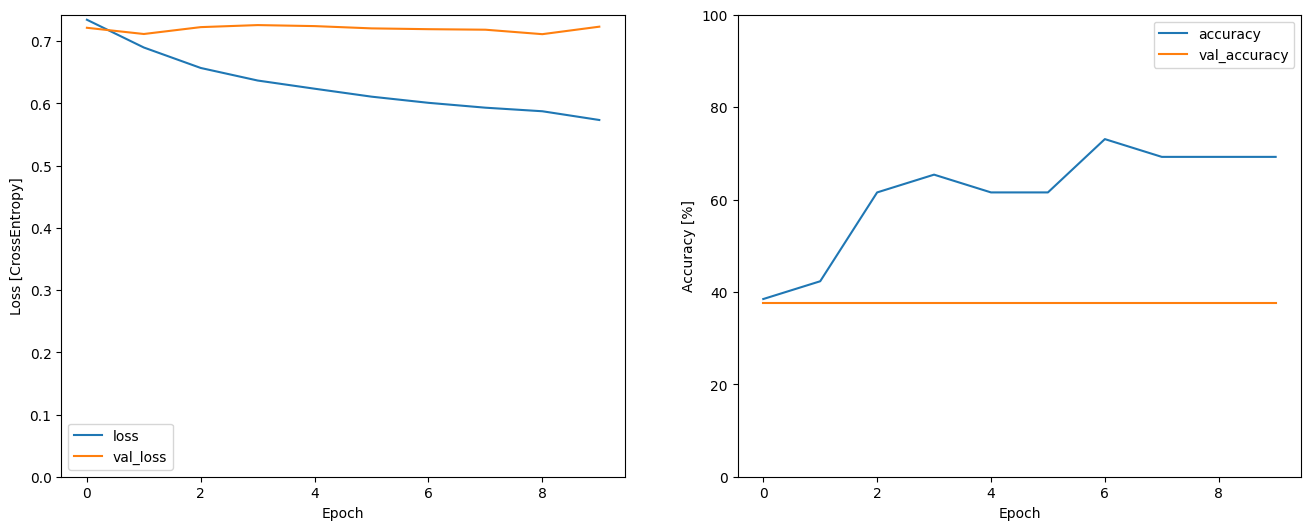

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/10
4/4 [==============================] - 1s 76ms/step - loss: 0.8231 - accuracy: 0.2692 - val_loss: 0.6944 - val_accuracy: 0.4904
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7946 - accuracy: 0.2692 - val_loss: 0.6860 - val_accuracy: 0.4712
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7617 - accuracy: 0.2692 - val_loss: 0.6808 - val_accuracy: 0.4712
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7479 - accuracy: 0.3462 - val_loss: 0.6776 - val_accuracy: 0.5481
Epoch 5/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7255 - accuracy: 0.3846 - val_loss: 0.6726 - val_accuracy: 0.5577
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7153 - accuracy: 0.4615 - val_loss: 0.6697 - val_accuracy: 0.5577
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7030 - accuracy: 0.5385 - val_loss: 0.6671 - val_accuracy: 0.5769
Epoch 8/10
4/4 [===========

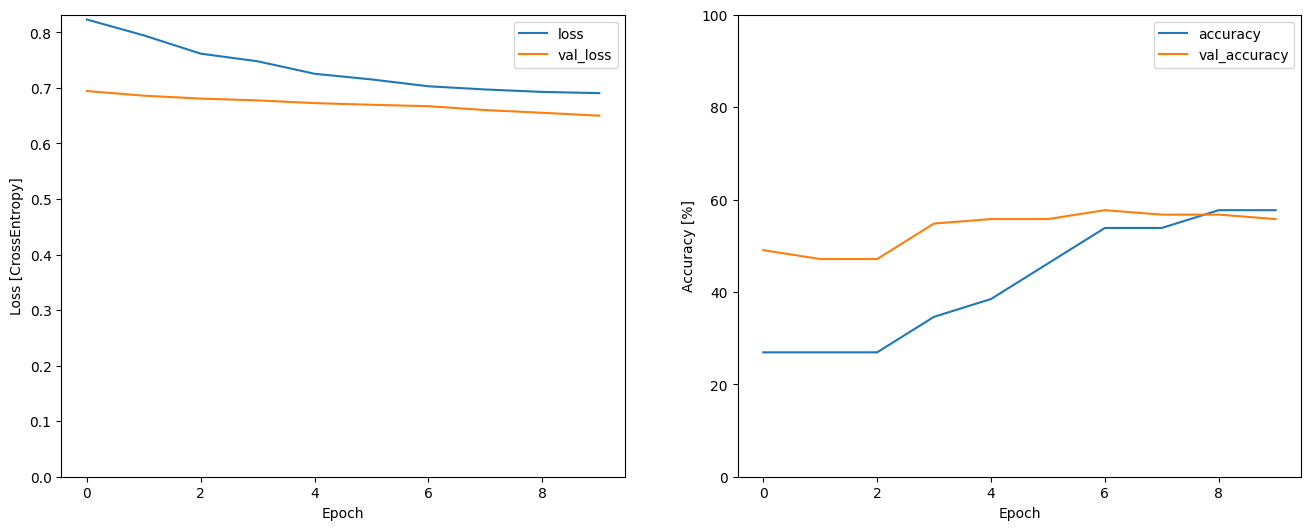

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


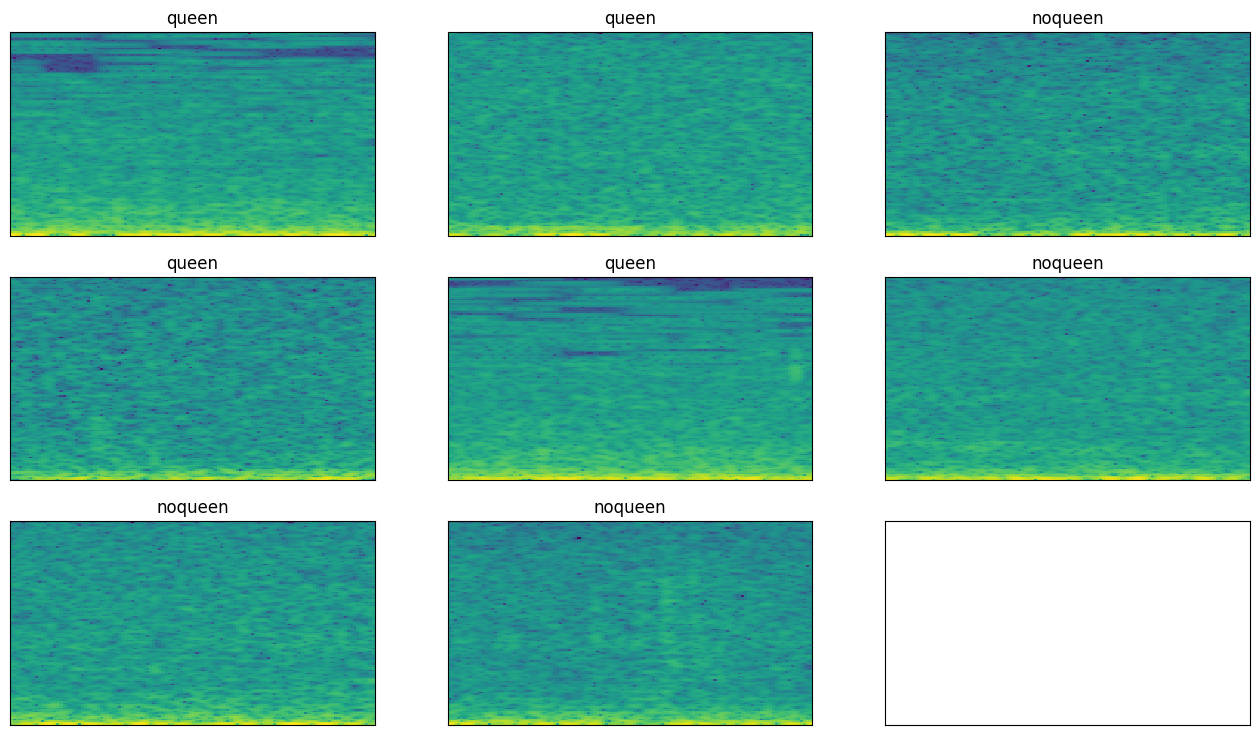

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/10
4/4 [==============================] - 1s 106ms/step - loss: 0.7266 - accuracy: 0.3462 - val_loss: 0.6738 - val_accuracy: 0.6154
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 0.6806 - accuracy: 0.5769 - val_loss: 0.6763 - val_accuracy: 0.6154
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 0.6612 - accuracy: 0.6923 - val_loss: 0.6798 - val_accuracy: 0.4808
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 0.6250 - accuracy: 0.6538 - val_loss: 0.6763 - val_accuracy: 0.5865
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 0.6043 - accuracy: 0.6538 - val_loss: 0.6766 - val_accuracy: 0.6442
Epoch 6/10
4/4 [==============================] - 0s 38ms/step - loss: 0.5874 - accuracy: 0.6923 - val_loss: 0.6705 - val_accuracy: 0.6346
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 0.5672 - accuracy: 0.6923 - val_loss: 0.6754 - val_accuracy: 0.6442
Epoch 8/10
4/4 [==========

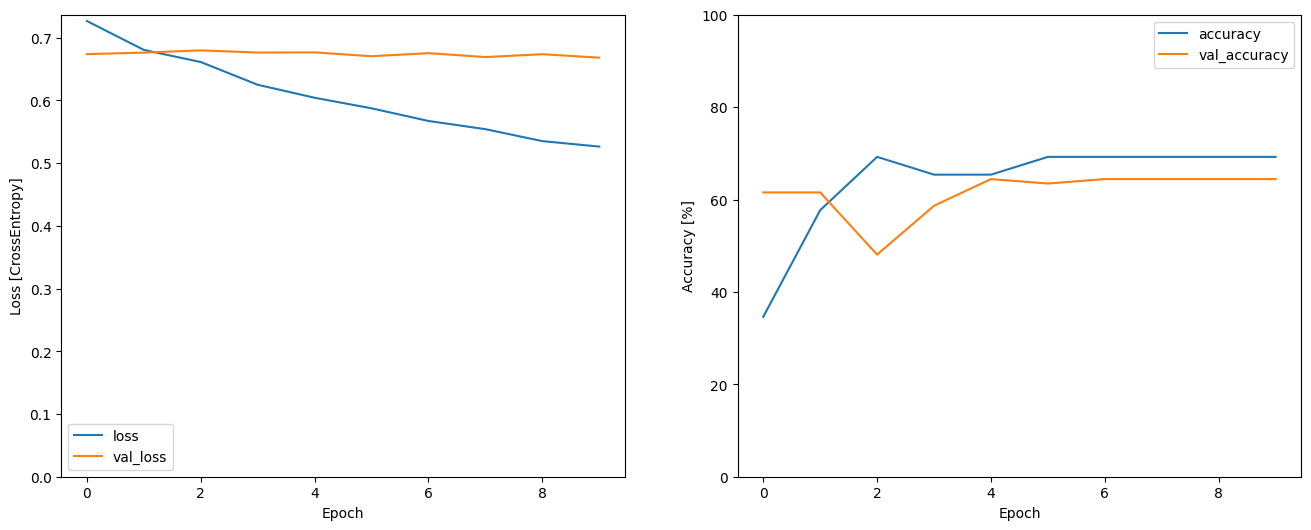

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/10
4/4 [==============================] - 1s 81ms/step - loss: 0.7097 - accuracy: 0.5769 - val_loss: 0.7280 - val_accuracy: 0.3750
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 0.7050 - accuracy: 0.5769 - val_loss: 0.7135 - val_accuracy: 0.3750
Epoch 3/10
4/4 [==============================] - 0s 29ms/step - loss: 0.6952 - accuracy: 0.5769 - val_loss: 0.7093 - val_accuracy: 0.3750
Epoch 4/10
4/4 [==============================] - 0s 28ms/step - loss: 0.6922 - accuracy: 0.5769 - val_loss: 0.7101 - val_accuracy: 0.3750
Epoch 5/10
4/4 [==============================] - 0s 30ms/step - loss: 0.6883 - accuracy: 0.5769 - val_loss: 0.7127 - val_accuracy: 0.3750
Epoch 6/10
4/4 [==============================] - 0s 28ms/step - loss: 0.6825 - accuracy: 0.5769 - val_loss: 0.7143 - val_accuracy: 0.3750
Epoch 7/10
4/4 [==============================] - 0s 29ms/step - loss: 0.6780 - accuracy: 0.5769 - val_loss: 0.7086 - val_accuracy: 0.3750
Epoch 8/10
4/4 [===========

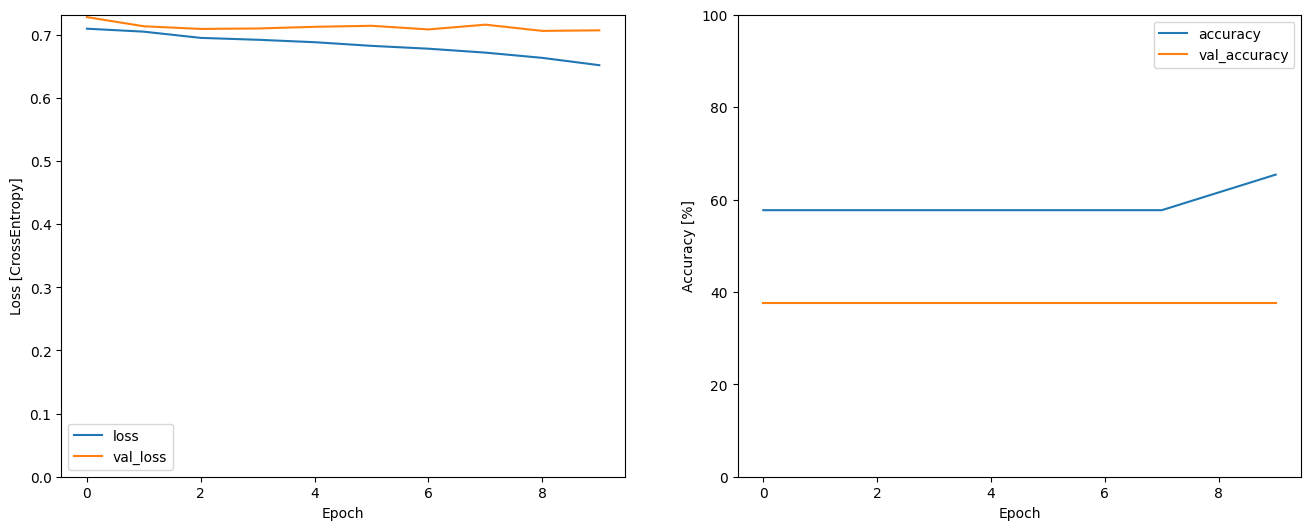

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

13/13 [==============================] - 0s 7ms/step - loss: 2.6376 - accuracy: 0.3558
MFCC Seq: [2.637627124786377, 0.35576921701431274]
13/13 [==============================] - 0s 4ms/step - loss: 1.3688 - accuracy: 0.3750
MFCC Conv: [1.3687987327575684, 0.375]
13/13 [==============================] - 0s 7ms/step - loss: 1.6187 - accuracy: 0.3750
Spec Seq: [1.6186975240707397, 0.375]
13/13 [==============================] - 0s 4ms/step - loss: 2.3082 - accuracy: 0.3750
Spec Conv: [2.3081984519958496, 0.375]


### [Reinf] [MFCCs] Sequential model

Epoch 1/10
4/4 [==============================] - 0s 63ms/step - loss: 2.1827 - accuracy: 0.4231 - val_loss: 1.4475 - val_accuracy: 0.2981
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 1.6141 - accuracy: 0.3846 - val_loss: 1.0904 - val_accuracy: 0.4615
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 1.2675 - accuracy: 0.5385 - val_loss: 1.0929 - val_accuracy: 0.5192
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 0.9353 - accuracy: 0.6923 - val_loss: 1.0664 - val_accuracy: 0.5481
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 0.8085 - accuracy: 0.7692 - val_loss: 1.0732 - val_accuracy: 0.5673
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 0.7494 - accuracy: 0.7308 - val_loss: 1.4724 - val_accuracy: 0.5769
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 0.5175 - accuracy: 0.7308 - val_loss: 1.4810 - val_accuracy: 0.5962
Epoch 8/10
4/4 [===========

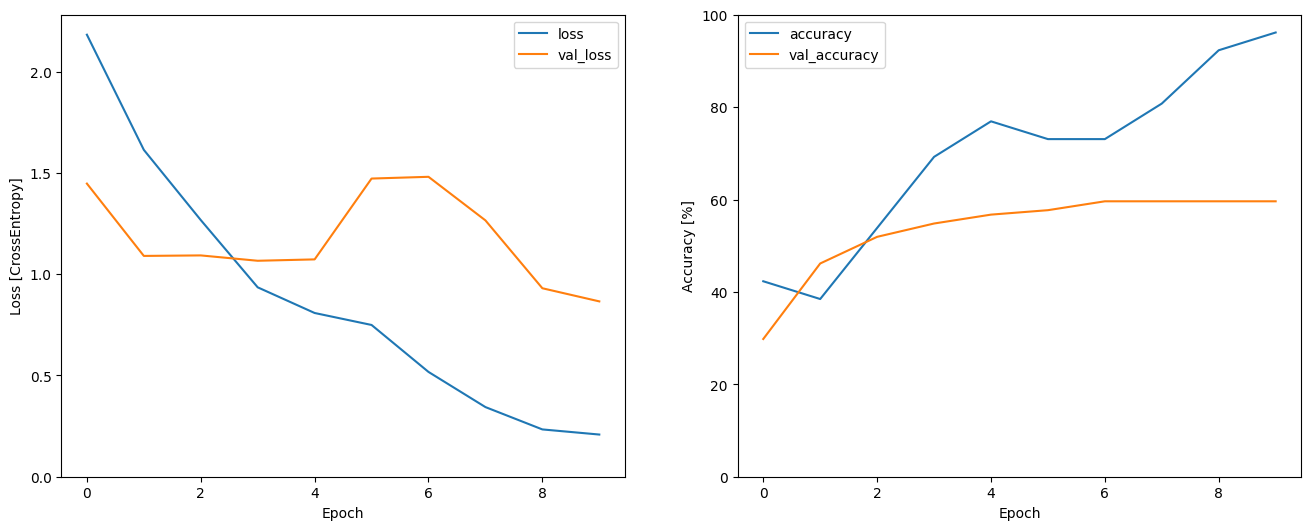

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/10
4/4 [==============================] - 0s 41ms/step - loss: 0.9839 - accuracy: 0.5385 - val_loss: 1.2737 - val_accuracy: 0.3558
Epoch 2/10
4/4 [==============================] - 0s 18ms/step - loss: 0.8458 - accuracy: 0.5385 - val_loss: 1.0098 - val_accuracy: 0.3558
Epoch 3/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7447 - accuracy: 0.6923 - val_loss: 0.8371 - val_accuracy: 0.5192
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7905 - accuracy: 0.6923 - val_loss: 0.7742 - val_accuracy: 0.6154
Epoch 5/10
4/4 [==============================] - 0s 17ms/step - loss: 0.8676 - accuracy: 0.6154 - val_loss: 0.7535 - val_accuracy: 0.6154
Epoch 6/10
4/4 [==============================] - 0s 17ms/step - loss: 0.8324 - accuracy: 0.5769 - val_loss: 0.7118 - val_accuracy: 0.7019
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7554 - accuracy: 0.6154 - val_loss: 0.6704 - val_accuracy: 0.7019
Epoch 8/10
4/4 [===========

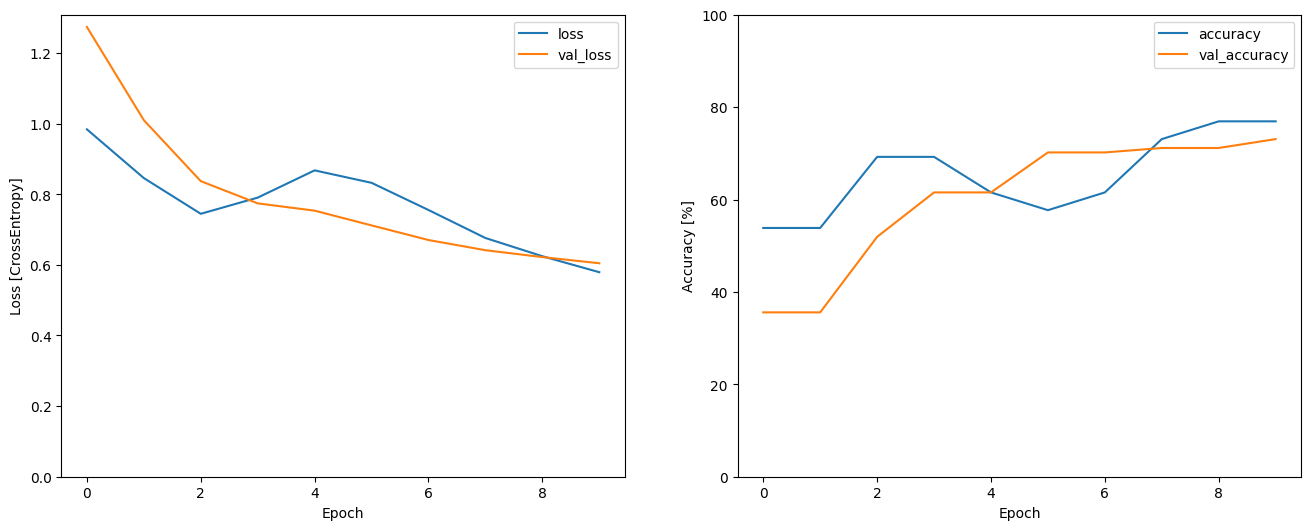

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/10
4/4 [==============================] - 0s 66ms/step - loss: 1.2607 - accuracy: 0.5769 - val_loss: 0.8676 - val_accuracy: 0.5385
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 0.7636 - accuracy: 0.5769 - val_loss: 0.6173 - val_accuracy: 0.3942
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 0.8683 - accuracy: 0.3846 - val_loss: 0.6035 - val_accuracy: 0.6346
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 0.8295 - accuracy: 0.6538 - val_loss: 0.5804 - val_accuracy: 0.4231
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 0.7351 - accuracy: 0.5769 - val_loss: 0.6128 - val_accuracy: 0.6442
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 0.6554 - accuracy: 0.5385 - val_loss: 0.6635 - val_accuracy: 0.6442
Epoch 7/10
4/4 [==============================] - 0s 40ms/step - loss: 0.6362 - accuracy: 0.6154 - val_loss: 0.6563 - val_accuracy: 0.6442
Epoch 8/10
4/4 [===========

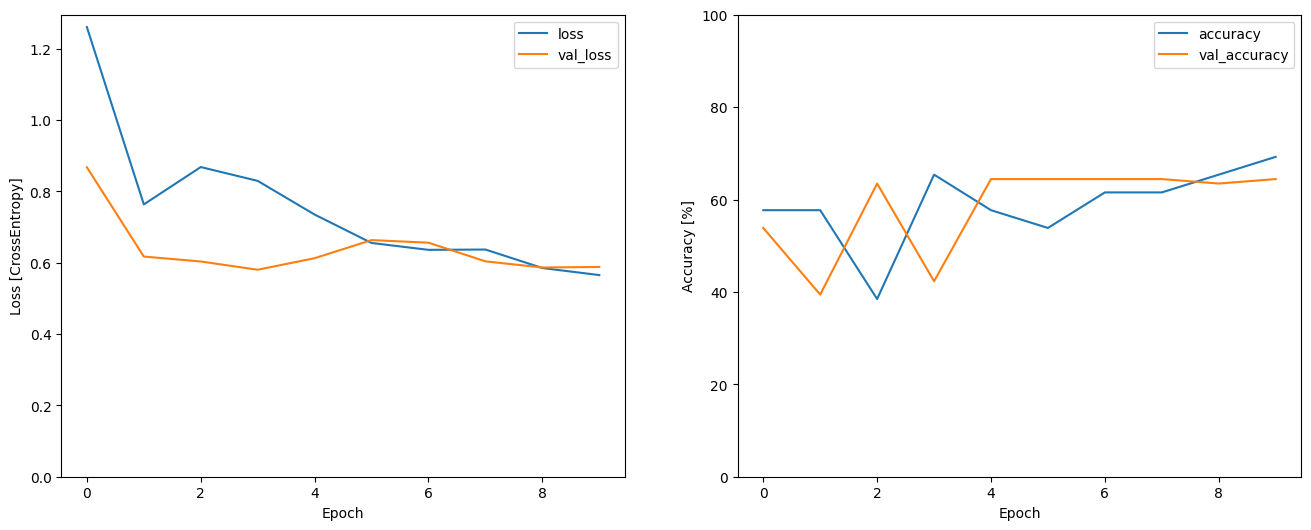

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/10
4/4 [==============================] - 0s 47ms/step - loss: 1.4929 - accuracy: 0.5769 - val_loss: 1.4166 - val_accuracy: 0.3846
Epoch 2/10
4/4 [==============================] - 0s 23ms/step - loss: 0.8455 - accuracy: 0.5385 - val_loss: 0.6458 - val_accuracy: 0.6442
Epoch 3/10
4/4 [==============================] - 0s 23ms/step - loss: 0.7158 - accuracy: 0.5769 - val_loss: 0.5977 - val_accuracy: 0.6442
Epoch 4/10
4/4 [==============================] - 0s 22ms/step - loss: 0.8410 - accuracy: 0.4615 - val_loss: 0.5866 - val_accuracy: 0.6442
Epoch 5/10
4/4 [==============================] - 0s 22ms/step - loss: 0.7202 - accuracy: 0.5000 - val_loss: 0.5615 - val_accuracy: 0.7692
Epoch 6/10
4/4 [==============================] - 0s 23ms/step - loss: 0.6095 - accuracy: 0.6154 - val_loss: 0.6706 - val_accuracy: 0.5192
Epoch 7/10
4/4 [==============================] - 0s 22ms/step - loss: 0.6353 - accuracy: 0.6154 - val_loss: 0.8057 - val_accuracy: 0.4231
Epoch 8/10
4/4 [===========

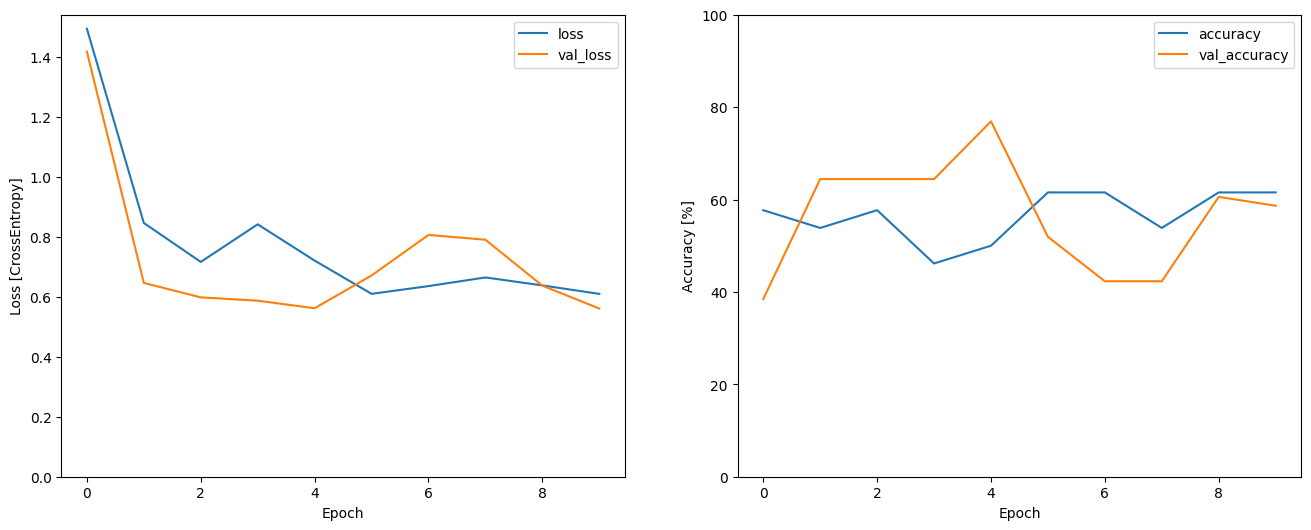

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
trained_model_mfcc_conv

# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f},  VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
# history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
# history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
# history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
# history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Conv      :    Loss: 0.69, VLoss: 0.65, Acc: 0.58,  VAcc: 0.56
Spectrogram + Conv:    Loss: 0.65, VLoss: 0.71, Acc: 0.65,  VAcc: 0.38

=== TRAINED ===
Tr. MFCCs + Conv      :    Loss: 0.58, VLoss: 0.60, Acc: 0.77,  VAcc: 0.73
Tr. Spectrogram + Conv:    Loss: 0.61, VLoss: 0.56, Acc: 0.62,  VAcc: 0.59
